# Model Analysis
Let's test the model and see how well it's doing

In [1]:
import sys
sys.path.append('../src/') 
import numpy as np
import torch
import Core as C
import math
import pickle
import pandas as pd
import time
import matplotlib.pyplot as plt
import Bio

In [2]:
%load_ext autoreload

In [3]:
autoreload

First, we need to load back in the model with weights.

In [4]:
ntokens = 5 # the size of vocabulary
emsize = 10 # embedding dimension
nhid = 10 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 3 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 5 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = C.model.TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-8, betas=(0.9, 0.8))
checkpoint = torch.load('./ModelSaves/Save-290.pt')
#checkpoint = torch.load('./ModelSaves/Save-50-v2.pt')

In [5]:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [6]:
model = model.cpu()

In [7]:
with open('./Pickle_storage/test_data_tokenized_WA.pkl', 'rb') as handle:
    data, embed_map = pickle.load(handle) # We stored the data and embedding map in one file
debed_map = {v: k for k, v in embed_map.items()}
ds_test = C.dataset.Dataset(data, embed=embed_map)
#ds_test.drop_dashes()
#ds_test.make_subseqs(length=200)
bs=1
if bs != 1:
    dl_test = torch.utils.data.DataLoader(ds_test, batch_size=bs, pin_memory=False)  # The data loader
else:
    dl_test = torch.utils.data.DataLoader(ds_test, batch_size=bs, pin_memory=True)  # The data loader


In [197]:
ds_test.full_data[0].keys()

dict_keys(['key', 'seq', 'label_seq', 'tokens', 'drop_pos'])

In [69]:
preds = []
raw_preds = []
seq_seen = []
all_targets = []
all_probs = []
for batch in dl_test:
    with torch.no_grad():
        seq, targets = batch
        if bs==1:
            seq = torch.flatten(torch.as_tensor(seq['tokens']))
            seq = seq.view(1,-1)
            #print(seq.shape)
        all_targets.append(targets.numpy())
        pred, probs = model.predict(seq)
        probs = np.squeeze(probs.numpy())
        all_probs.append(probs)
        raw_preds.append(pred)
        seq_seen.append(seq.numpy())
        #print(type(pred))
        preds.append(np.equal(pred, targets.numpy()).flatten())

In [151]:
len(raw_preds)

799

In [93]:
np.mean(np.asarray([np.equal(raw_preds[test_idx], all_targets[test_idx]).sum() for test_idx in range(100)]))

1633.3

In [71]:
raw_preds[0]

array([[0, 0, 0, ..., 0, 0, 1]])

In [72]:
np.bincount(raw_preds[0].flatten())

array([1525,  714])

In [73]:
np.bincount(all_targets[0].flatten())

array([1169, 1070])

In [91]:
np.bincount(np.equal(raw_preds[test_idx], all_targets[test_idx]).flatten())

array([ 609, 1628])

In [92]:
raw_preds[test_idx][0]

array([0, 0, 0, ..., 0, 0, 1])

In [95]:
max_probs = [np.max(ar, axis=1) for ar in all_probs]

Now let's compute some basic statistics on the output. First, is our model better than just guessing using the average number of `0`'s and `1`'s?

In [94]:
preds[0]

array([ True,  True,  True, ..., False,  True,  True])

In [96]:
preds[0].shape

(2239,)

In [97]:
np.bincount(preds[0])

array([ 604, 1635])

In [98]:
avg_acc = np.concatenate(preds).mean()
print('Model accuracy on WA test data:', avg_acc * 100, '%')
lf_acc = np.concatenate(all_targets, axis=1).mean()
print('Random guessing using only label frequencies', lf_acc * 100, '%')
print('The overall improvement is ', (avg_acc- lf_acc)  * 100, '%')

Model accuracy on WA test data: 72.6236573753624 %
Random guessing using only label frequencies 47.92393442465215 %
The overall improvement is  24.69972295071024 %


So we have a 24.6% improvement in prediction quality over using the native labels.

Next, we ask what percentage of 

In [70]:
raw_preds[0].mean()

0.31889236266190263

In [11]:
test_idx = 9
letters = [debed_map[v.item()] for v in np.nditer(seq_seen[test_idx][0,:])]
numerical_tokens = [v.item() for v in np.nditer(seq_seen[test_idx][0,:])]
labels = [v.item() for v in np.nditer(all_targets[test_idx][0,:])]
predsl = [int(v.item()) for v in np.nditer(raw_preds[test_idx][0,:])]
max_prob_val = max_probs[test_idx]

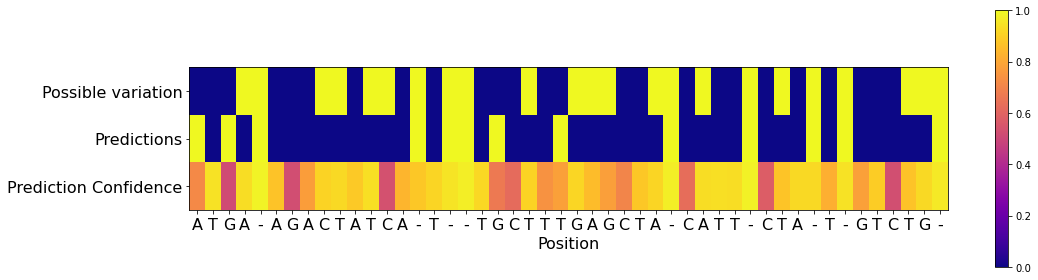

In [143]:
sl = 16
start = 0
view_start, view_end = start, 3*(start + sl)
fig, ax = plt.subplots(1,1, figsize=(16,4))
v = ''
DNA_seq_ = letters[view_start:view_end]
for token in DNA_seq_:
    v += token
ax = [ax]
im1 = ax[0].imshow(np.asarray([labels,labels,labels, predsl,predsl,predsl , max_prob_val,max_prob_val,max_prob_val])[:, view_start:view_end], cmap='plasma')
#ax[1].imshow(np.asarray([numerical_tokens] * 6)[:, view_start:view_end])
ax[0].set_yticks([1, 4, 7])
ax[0].set_yticklabels(['Possible variation', 'Predictions', 'Prediction Confidence'], fontsize=16)
ax[0].set_xticks(np.arange(view_end-view_start))
ax[0].set_xticklabels(DNA_seq_, fontsize=16)
#ax[1].set_yticks([])
ax[0].set_xlabel('Position', fontsize=16)
#ax[1].set_xlabel('Position')
#ax[0]
#ax[0].set_aspect('equal')
plt.colorbar(im1)
plt.tight_layout()
plt.savefig('./Images/SequencePredictionPlot.eps')
plt.savefig('./Images/SequencePredictionPlot.png')
plt.show()

In [36]:
preds_np = np.concatenate([np.squeeze(ar) for ar in preds])
raw_preds_np = np.concatenate([np.squeeze(ar) for ar in raw_preds])
seq_seen_np = np.concatenate([np.squeeze(ar) for ar in seq_seen])
all_targets_np = np.concatenate([np.squeeze(ar) for ar in all_targets])
A_loc = np.where(seq_seen_np == 0)
C_loc = np.where(seq_seen_np==1)
T_loc = np.where(seq_seen_np==2)
G_loc = np.where(seq_seen_np==3)
skip_loc = np.where(seq_seen_np==4)

In [116]:
 np.where(seq_seen_np == 2)

(array([      1,       9,      11, ..., 1662865, 1662866, 1662878]),)

In [115]:
print(seq_seen_np[0:20])

[0 2 3 0 3 4 3 0 1 2 0 2 1 0 4 2 4 4 2 3]


### Variable sites?

Next, we ask what percentage of nucleotide sites are variable.

First, a direct mean calculation, get a population level statistic.

In [148]:
np.hstack([raw_preds_np[test_loc] for test_loc in [A_loc, C_loc, T_loc, G_loc]]).mean()

0.10725466560458419

### Distribution of percentage of variable sites?
Now we ask for the distribution. We ignore skip characters for this section.

In [188]:
var_sites_counts = []
seq_len_list = []
for seq, preds in zip(seq_seen, raw_preds):
    
    non_gap = np.where(seq[0].flatten() != 4)
    
    var_sites_counts.append(preds.flatten()[non_gap].sum())
    seq_len_list.append(preds.flatten()[non_gap].shape[0])

In [190]:
perc_var = [v/q for v,q in zip(var_sites_counts, seq_len_list)]

(array([ 3.,  1.,  4.,  7., 18., 11., 27., 24., 26., 20., 29., 31., 33.,
        28., 35., 16., 29., 25., 37., 22., 33., 45., 28., 35., 33., 43.,
        30., 27., 21., 23., 12., 15.,  8.,  9.,  3.,  4.,  1.,  2.,  0.,
         1.]),
 array([126.   , 128.475, 130.95 , 133.425, 135.9  , 138.375, 140.85 ,
        143.325, 145.8  , 148.275, 150.75 , 153.225, 155.7  , 158.175,
        160.65 , 163.125, 165.6  , 168.075, 170.55 , 173.025, 175.5  ,
        177.975, 180.45 , 182.925, 185.4  , 187.875, 190.35 , 192.825,
        195.3  , 197.775, 200.25 , 202.725, 205.2  , 207.675, 210.15 ,
        212.625, 215.1  , 217.575, 220.05 , 222.525, 225.   ]),
 <BarContainer object of 40 artists>)

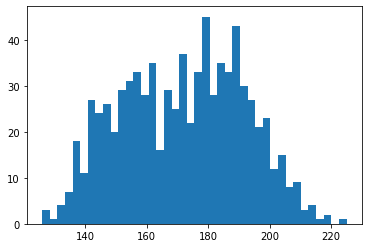

In [189]:
plt.hist(var_sites_counts, bins=40)

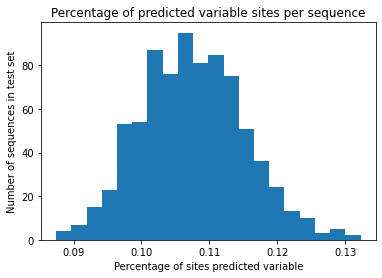

In [207]:
plt.hist(perc_var, bins=20)
plt.xlabel('Percentage of sites predicted variable')
plt.ylabel('Number of sequences in test set')
plt.title('Percentage of predicted variable sites per sequence')
plt.savefig('./Images/VarSitesDist.eps')
plt.savefig('./Images/VarSitesDist.png')


Now we want to know if the bases themselves are useful in this prediction problem.

In [99]:
embed_map

{'A': 0, 'C': 1, 'T': 2, 'G': 3, '-': 4}

In [201]:
# Check that we didn't loose any bases before we compute per-base statistics.
sum(item[0].shape[0] for item in [A_loc, C_loc, T_loc, G_loc, skip_loc])

1662881

In [101]:
from sklearn import metrics

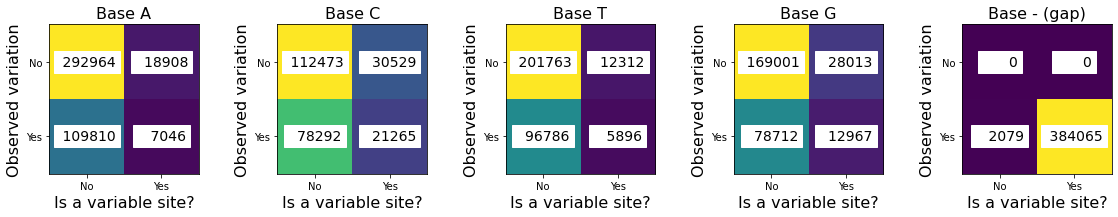

In [213]:
fig, ax = plt.subplots(1,5, figsize=(16,3))
for idx, va in enumerate(zip(['A', 'C', 'T', 'G', '- (gap)'], [A_loc, C_loc, T_loc, G_loc, skip_loc])):
    let, loc = va
    loc = loc[0]
    #print(type(va[1][0]), va[1][0])
    #data_conf_mat_n = metrics.confusion_matrix(all_targets_np[loc].astype(int), (preds_np[loc]).astype(int), normalize='true')
    #print(data_conf_mat_n, '\n')
    data_conf_mat = metrics.confusion_matrix(all_targets_np[loc].astype(int), (raw_preds_np[loc]).astype(int))
    #print(data_conf_mat, '\n')
    ax[idx].imshow(data_conf_mat, vmin=0)
    ax[idx].set_title(f'Base {let}', fontsize=16)
    #ax[idx].set_title(f'Base {let} Confusion matrix', fontsize=16)
    ax[idx].set_xticks([0,1])
    ax[idx].set_yticks([0,1])
    ax[idx].set_xlabel('Is a variable site?', fontsize=16)
    ax[idx].set_ylabel('Observed variation', fontsize=16)
    #ax[idx].set_yticklabels(['Label 0', 'label 1' ])
    #ax[idx].set_xticklabels(['Predicted 0', 'Predicted 1'])
    ax[idx].set_yticklabels(['No', 'Yes' ])
    ax[idx].set_xticklabels(['No', 'Yes'])

    for (i, j), z in np.ndenumerate(data_conf_mat):
        text = ax[idx].text(j, i, '{:7d}'.format(z), ha='center', va='center', c='k', fontsize=14)
        text.set_backgroundcolor('w')
plt.tight_layout()
plt.savefig(f'./Images/ConfMat_nonrm.png')
plt.savefig(f'./Images/ConfMat_nonrm.eps')
plt.show()
    

[[0.93937256 0.06062744]
 [0.93970357 0.06029643]] 

[[0.78651348 0.21348652]
 [0.78640377 0.21359623]] 

[[0.94248745 0.05751255]
 [0.94258    0.05742   ]] 

[[0.85781214 0.14218786]
 [0.85856085 0.14143915]] 

[[0.       0.      ]
 [0.005384 0.994616]] 



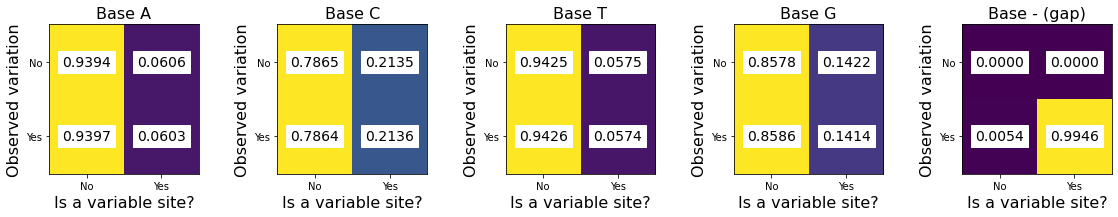

In [221]:
fig, ax = plt.subplots(1,5, figsize=(16,3))
for idx, va in enumerate(zip(['A', 'C', 'T', 'G', '- (gap)'], [A_loc, C_loc, T_loc, G_loc, skip_loc])):
    let, loc = va
    loc = loc[0]
    #print(type(va[1][0]), va[1][0])
    #data_conf_mat_n = metrics.confusion_matrix(all_targets_np[loc].astype(int), (preds_np[loc]).astype(int), normalize='true')
    #print(data_conf_mat_n, '\n')
    data_conf_mat = metrics.confusion_matrix(all_targets_np[loc].astype(int), (raw_preds_np[loc]).astype(int), normalize='true')
    print(data_conf_mat, '\n')
    ax[idx].imshow(data_conf_mat, vmin=0)
    ax[idx].set_title(f'Base {let}', fontsize=16)
    #ax[idx].set_title(f'Base {let} Confusion matrix', fontsize=16)
    ax[idx].set_xticks([0,1])
    ax[idx].set_yticks([0,1])
    ax[idx].set_xlabel('Is a variable site?', fontsize=16)
    ax[idx].set_ylabel('Observed variation', fontsize=16)
    #ax[idx].set_yticklabels(['Label 0', 'label 1' ])
    #ax[idx].set_xticklabels(['Predicted 0', 'Predicted 1'])
    ax[idx].set_yticklabels(['No', 'Yes' ])
    ax[idx].set_xticklabels(['No', 'Yes'])
    for (i, j), z in np.ndenumerate(data_conf_mat):
        #print(z)
        text = ax[idx].text(j, i, '{:.4f}'.format(z), ha='center', va='center', c='k', fontsize=14)
        text.set_backgroundcolor('w')
plt.tight_layout()
plt.savefig(f'./Images/ConfMat_rownorm.png')
plt.savefig(f'./Images/ConfMat_rownorm.eps')
plt.show()


In [131]:
print(metrics.f1_score(all_targets_np.astype(int), preds_np.astype(int)))

0.4303013733075628


In [40]:
np.where(all_targets_np[loc].astype(int) == (preds_np[loc]).astype(int))[0].shape[0] / preds_np[loc].shape[0]

0.994615998176846

In [41]:
all_targets_np[T_loc].sum()

102682

In [567]:
(preds_np[loc]).astype(int).sum()

207671

In [525]:
all_targets_np

array([0, 0, 0, ..., 0, 1, 1])

In [545]:
embed_map

{'A': 0, 'C': 1, 'T': 2, 'G': 3, '-': 4}

(array([0.32227802, 0.1823334 , 0.23810859, 0.21701267, 0.29026731]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

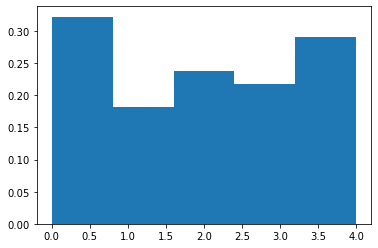

In [603]:
plt.hist(seq_seen_np, bins=5, density=True)